In [1]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pathlib 
import shutil 


np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")


TensorFlow Version: 2.15.0


In [2]:

data_dir = pathlib.Path('Garbage classification/Garbage classification')


if not data_dir.exists():
    print(f"Error: Dataset directory not found at {data_dir}")
    print("Please ensure the 'garbage_classification' folder is in the same directory as your notebook.")
else:
    print(f"Dataset found at: {data_dir}")


IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32


class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Classes found: {class_names}")
num_classes = len(class_names)



test_dir = pathlib.Path('test_garbage_data')

if test_dir.exists():
    shutil.rmtree(test_dir)
os.makedirs(test_dir, exist_ok=True)


test_split_ratio = 0.15 

print("\nCreating separate test set...")
for class_name in class_names:
    class_path = data_dir / class_name
    test_class_path = test_dir / class_name
    os.makedirs(test_class_path, exist_ok=True)

    images = list(class_path.glob('*.jpg')) + list(class_path.glob('*.jpeg')) + list(class_path.glob('*.png'))
    random.shuffle(images) 

    num_test_images = int(len(images) * test_split_ratio)
    
  
    for i in range(num_test_images):
     
        shutil.move(str(images[i]), str(test_class_path / images[i].name))
    print(f"Moved {num_test_images} images from {class_name} to test set.")

print(f"\nTraining/Validation data now in: {data_dir}")
print(f"Separate Test data in: {test_dir}")


train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    shear_range=0.2,       
    zoom_range=0.2,       
    horizontal_flip=True   
)


val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    subset='training', 
    seed=42
)


validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation', 
    seed=42
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=42
)

print(f"\nTotal training images: {train_generator.samples}")
print(f"Total validation images: {validation_generator.samples}")
print(f"Total test images: {test_generator.samples}")


class_indices = train_generator.class_indices

idx_to_class = {v: k for k, v in class_indices.items()}

Dataset found at: Garbage classification\Garbage classification
Classes found: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Creating separate test set...
Moved 43 images from cardboard to test set.
Moved 54 images from glass to test set.
Moved 44 images from metal to test set.
Moved 64 images from paper to test set.
Moved 52 images from plastic to test set.
Moved 15 images from trash to test set.

Training/Validation data now in: Garbage classification\Garbage classification
Separate Test data in: test_garbage_data
Found 1250 images belonging to 6 classes.
Found 309 images belonging to 6 classes.
Found 272 images belonging to 6 classes.

Total training images: 1250
Total validation images: 309
Total test images: 272


In [3]:

model = Sequential([
   
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(), 

    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),


    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Flatten(), 

    # Dense layers
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(num_classes, activation='softmax') 
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                      

In [4]:

EPOCHS = 20 

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE 
)

Epoch 1/20


39/39 [==============================] - 7s 160ms/step - loss: 5.2893 - accuracy: 0.3990 - precision: 0.4120 - recall: 0.3826 - val_loss: 3.6494 - val_accuracy: 0.2396 - val_precision: 0.2396 - val_recall: 0.2396
Epoch 2/20
39/39 [==============================] - 6s 142ms/step - loss: 3.4844 - accuracy: 0.4573 - precision: 0.5112 - recall: 0.4122 - val_loss: 2.6970 - val_accuracy: 0.2361 - val_precision: 0.2301 - val_recall: 0.1806
Epoch 3/20
39/39 [==============================] - 6s 144ms/step - loss: 2.8953 - accuracy: 0.4483 - precision: 0.5474 - recall: 0.3695 - val_loss: 5.2677 - val_accuracy: 0.2188 - val_precision: 0.2199 - val_recall: 0.2153
Epoch 4/20
39/39 [==============================] - 6s 143ms/step - loss: 2.3188 - accuracy: 0.4975 - precision: 0.6295 - recall: 0.3990 - val_loss: 2.7266 - val_accuracy: 0.2257 - val_precision: 0.2722 - val_recall: 0.1701
Epoch 5/20
39/39 [==============================] - 8s 208ms/step - loss: 1.9411 - accuracy: 0.5136 - 


--- Model Evaluation on Test Set ---
9/9 [==============================] - 0s 46ms/step - loss: 4.0392 - accuracy: 0.3640 - precision: 0.3865 - recall: 0.2941
Test Loss: 4.0392
Test Accuracy: 0.3640
Test Precision: 0.3865
Test Recall: 0.2941
Test F1-score: 0.3340


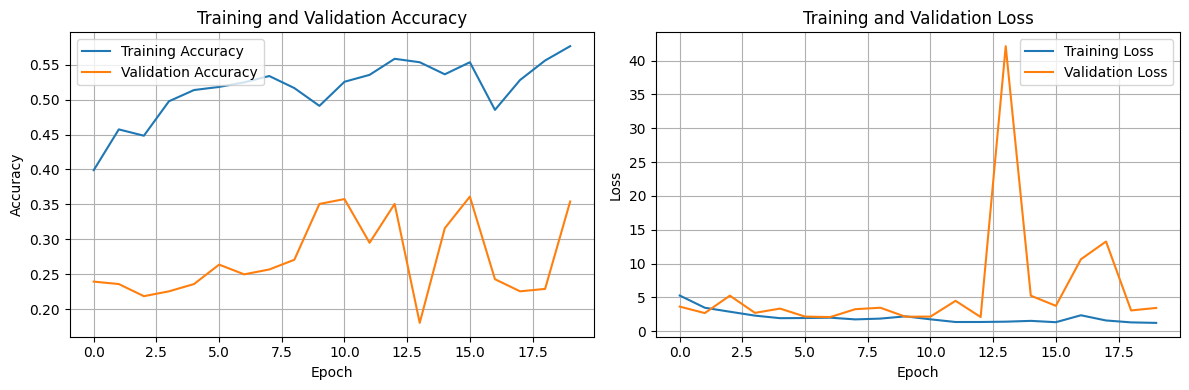


--- Generating Confusion Matrix ---
9/9 [==============================] - 0s 39ms/step


<Figure size 1000x800 with 0 Axes>

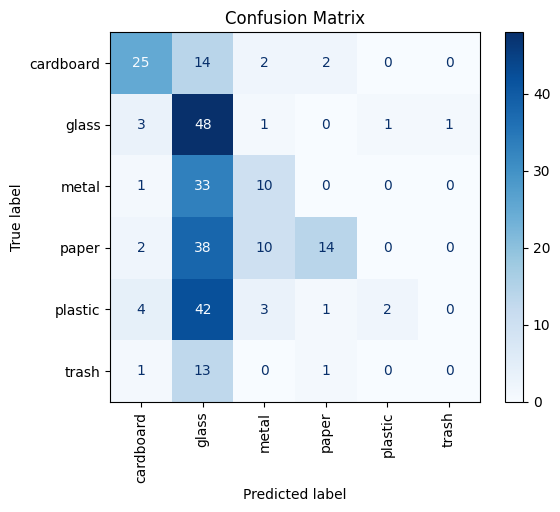

In [5]:

print("\n--- Model Evaluation on Test Set ---")

test_generator.reset()
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + tf.keras.backend.epsilon())
print(f"Test F1-score: {f1_score:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


print("\n--- Generating Confusion Matrix ---")


test_generator.reset()
test_labels = test_generator.classes


predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)


cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


--- Demonstrating Model Predictions (Diverse Examples) ---
Collected 256 predictions from the test set.
Selected 3 diverse correct predictions.
Selected 3 diverse incorrect predictions.

--- Correct Predictions (Diverse Examples) ---


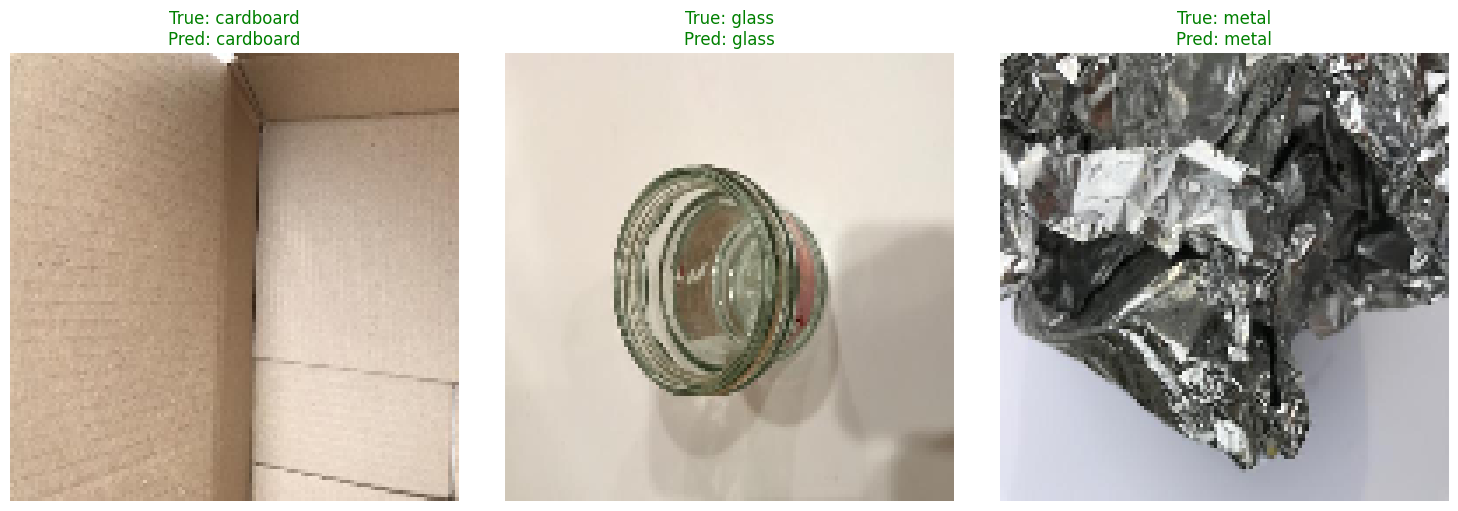


--- Incorrect Predictions (Diverse Examples) ---


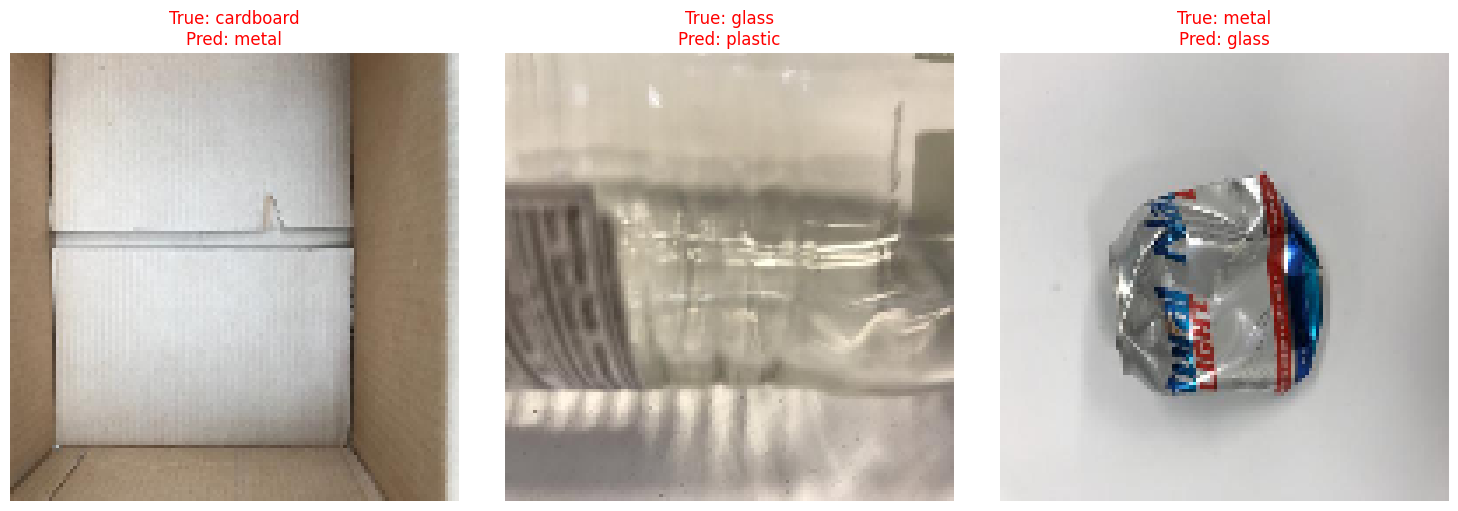

In [6]:

print("\n--- Demonstrating Model Predictions (Diverse Examples) ---")


all_predictions = []
true_labels_list = []

test_generator.reset()


for i in range(test_generator.samples // test_generator.batch_size):
    images, labels = next(test_generator)
    batch_preds = model.predict(images, verbose=0) 
    
    predicted_classes = np.argmax(batch_preds, axis=1)
    true_classes = np.argmax(labels, axis=1)

    for j in range(len(images)):
        true_label_name = idx_to_class[true_classes[j]]
        predicted_label_name = idx_to_class[predicted_classes[j]]
        
        all_predictions.append({
            'image': images[j],
            'true_label': true_label_name,
            'predicted_label': predicted_label_name,
            'is_correct': (true_label_name == predicted_label_name)
        })
        true_labels_list.append(true_label_name)

print(f"Collected {len(all_predictions)} predictions from the test set.")



diverse_correct_preds = []
seen_correct_classes = set()
for pred in all_predictions:
    if pred['is_correct'] and pred['true_label'] not in seen_correct_classes:
        diverse_correct_preds.append(pred)
        seen_correct_classes.add(pred['true_label'])
        if len(diverse_correct_preds) >= 3: 
            break

if len(diverse_correct_preds) < 3:
    diverse_correct_preds = [pred for pred in all_predictions if pred['is_correct']][:3]



diverse_incorrect_preds = []
seen_incorrect_classes = set()
for pred in all_predictions:
    if not pred['is_correct'] and pred['true_label'] not in seen_incorrect_classes:
        diverse_incorrect_preds.append(pred)
        seen_incorrect_classes.add(pred['true_label'])
        if len(diverse_incorrect_preds) >= 3: 
            break


if len(diverse_incorrect_preds) < 3:
    diverse_incorrect_preds = [pred for pred in all_predictions if not pred['is_correct']][:3]


print(f"Selected {len(diverse_correct_preds)} diverse correct predictions.")
print(f"Selected {len(diverse_incorrect_preds)} diverse incorrect predictions.")



if diverse_correct_preds:
    print("\n--- Correct Predictions (Diverse Examples) ---")
    plt.figure(figsize=(15, 5))
    for i, pred in enumerate(diverse_correct_preds[:3]): 
        plt.subplot(1, 3, i + 1)
        plt.imshow(pred['image'])
        plt.title(f"True: {pred['true_label']}\nPred: {pred['predicted_label']}", color='green')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\nCould not find any correct predictions to display.")



if diverse_incorrect_preds:
    print("\n--- Incorrect Predictions (Diverse Examples) ---")
    plt.figure(figsize=(15, 5))
    for i, pred in enumerate(diverse_incorrect_preds[:3]): 
        plt.subplot(1, 3, i + 1)
        plt.imshow(pred['image'])
        plt.title(f"True: {pred['true_label']}\nPred: {pred['predicted_label']}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\nCould not find any incorrect predictions to display.")


